In [2]:
import librosa, librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime

import json
import os
import math
import librosa

import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

In [3]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

## Audio Pre-Processing

Fourier Series
Fourier Transform
FFT -> STFT -> MFCC (13 - 40 features)


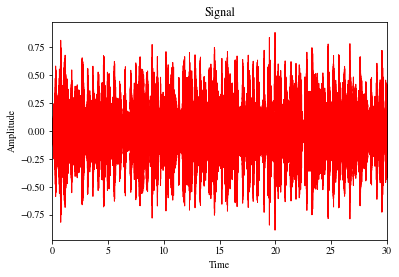

In [4]:
file = 'blues.00000.wav'

#waveform
signal, sr = librosa.load(file, sr = 22050) # sample rate * Time -> 22050 * 30
librosa.display.waveplot(signal, sr = sr, color = 'r')
plt.title("Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.savefig("Signal_raw.eps")
plt.show()

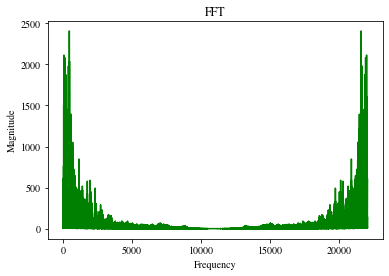

In [5]:
#Create FFT
fft = np.fft.fft(signal)
magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))
plt.plot(frequency, magnitude, color = 'g')
plt.title("FFT")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

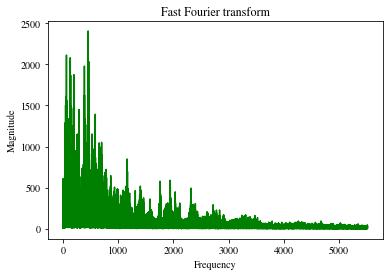

In [75]:
#observe Nyquist Theorem (sample rate symmetry)
#Cut magnitude array in half
magnitude = magnitude[:int(len(frequency)/2)]
frequency = frequency[:int(len(frequency)/2)]
plt.plot(frequency, magnitude, color = 'g')
plt.title("Fast Fourier transform")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.savefig('FFT.eps')
plt.show()

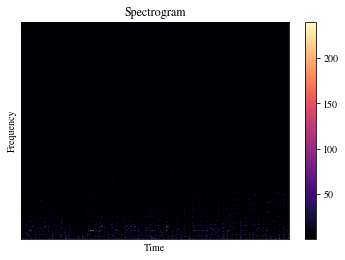

In [7]:
#Create STFT for info on frequency, magnitude and time
#Compute several FFT at different intervals to get frequency info over time
samples_per_fft = 2048 #number of samples
hop_length = 512 #Amount each FT is shifted
stft = librosa.core.stft(signal, hop_length = hop_length, n_fft = samples_per_fft)
spectrogram = np.abs(stft)
librosa.display.specshow(spectrogram, sr = sr, hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title('Spectrogram')
plt.savefig('Spectrogram.png')
plt.colorbar()
plt.show()

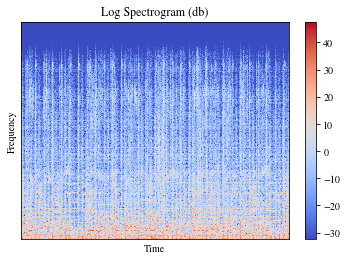

In [8]:
#hard to visualize, use log-spectrogram in db
log_spectrogram = librosa.amplitude_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, sr = sr, hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title('Log Spectrogram (db)')
plt.savefig('Log Spectrogram.eps')
plt.colorbar()
plt.show()

In [9]:
log_spectrogram.shape

(1025, 1293)

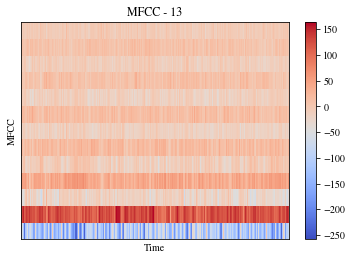

In [10]:
#Create MFCC
n_mfcc = 13

MFCC = librosa.feature.mfcc(signal, n_fft = samples_per_fft, hop_length = hop_length, n_mfcc = n_mfcc)
librosa.display.specshow(MFCC, sr = sr, hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.title('MFCC - 13')
plt.colorbar()
plt.savefig('MFCC.eps')
plt.show()

In [11]:
MFCC.shape

(13, 1293)

In [12]:
start_time = datetime.now()

## Full Dataset Pre-Processing
    - 10 Genres
    - 100 Songs Per Genre
    - 30 Seconds Per Song (lossless format, .WAV)
    - 22050 Hz Sample Rate
    - Mono Signal

In [13]:
# DATASET_PATH = 'c:/Users/StevensUser/Desktop/Audio_Analysis/GTZAN_Reduced'
DATASET_PATH = 'c:/Users/StevensUser/Desktop/Audio_Analysis/GTZAN Dataset Archive/genres_original'

# JSON_PATH = 'data_10.json'
JSON_PATH = "data_full.json"

# csv_path = "data_10.csv"
csv_path = "data_full.csv"

SAMPLE_RATE = 22050 # Hz
TRACK_DURATION = 30 # Sec
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [14]:
# SAMPLES_PER_TRACK

In [15]:
# Save as CSV using Pandas
def save_mfcc_csv(dataset_path, csv_path, num_mfcc = 13, n_fft = 2048, hop_length = 512, num_segments = 5):    
    
    MFCC_values = np.array([])
    genre_values = np.array([])
    genre_labels = np.array([])
    filename_list = np.array([])
    segment_list = np.array([])
    mfcc_count_list = np.array([])
    
    label_dict = {'blues': 1, 'classical': 2, 'country': 3, 
                  'disco':4, 'hiphop': 5, 'jazz': 6, 
                  'metal': 7, 'pop': 8, 'reggae': 9, 
                  'rock': 10}

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        
        if dirpath != dataset_path: 
            
            genre_name = dirpath.split("\\")[-1] #Genre (Output Label)
            
            print("Processing: ", genre_name)
            
            for f in filenames:
                
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr = SAMPLE_RATE) 
                
                for d in range(num_segments):
                    
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], 
                                                sample_rate, 
                                                n_mfcc=num_mfcc, 
                                                n_fft=n_fft, 
                                                hop_length=hop_length)
                    
                    mfcc = mfcc.T
                    
                    if len(mfcc) == num_mfcc_vectors_per_segment:   #Omit Vectors with off shaped MFCC Samples 
                        MFCC_values = np.append(MFCC_values, mfcc)
                        genre_values = np.append(genre_values, np.full(len(mfcc) * num_mfcc, fill_value = label_dict[genre_name]) )
                        genre_labels = np.append(genre_labels, np.full(len(mfcc) * num_mfcc, fill_value = genre_name) ) 
                        filename_list = np.append(filename_list, np.full(len(mfcc) * num_mfcc, fill_value = f))
                        segment_list = np.append(segment_list, np.full(len(mfcc) * num_mfcc, fill_value = d))
                        mfcc_count_list = np.append(mfcc_count_list, list(np.array([list(np.full(num_mfcc, fill_value = i)) for i in range(1, 10 * num_mfcc + 1)]).flatten()))

    
    output_df = pd.DataFrame({'MFCC_Values': MFCC_values, 
                              'Genre values': genre_values, 
                              'Genre Labels': genre_labels,
                              'Filename': filename_list,
                              'Segment': segment_list, 
                              'MFCC Count': mfcc_count_list})
    
    output_df.to_csv(csv_path, index = False)
    print('\noutput_saved to .csv')
#     return MFCC_values, genre_values, genre_labels, filename_list, segment_list, mfcc_count_list
    return output_df


# mfcc_temp, gv_temp, gl_temp, file_temp, segment_temp, mfcc_count_l_temp = save_mfcc_csv(DATASET_PATH, csv_path, num_segments=10)

In [16]:
# Leaving this commented to save runtime

# save_mfcc_csv(DATASET_PATH, csv_path, num_segments=10)

In [17]:
# Save as JSON 

# Github: https://github.com/musikalkemist/DeepLearningForAudioWithPython/blob/master/12-%20Music%20genre%20classification:%20Preparing%20the%20dataset/code/extract_data.py
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("\\")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

                # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
#                         print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        
        


In [18]:
# Will use .JSON data for analysis here
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


Processing: blues

Processing: classical

Processing: country

Processing: disco

Processing: hiphop

Processing: jazz

Processing: metal

Processing: pop

Processing: reggae

Processing: rock


In [19]:

def load_data(data_path):

    with open(data_path, "r") as d:
        data = json.load(d)

    #Load JSON data into two NP arrays, x -> MFCC, y -> labels(targets)
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])


    return  X, y


In [20]:
# path = 'c:/Users/StevensUser/Desktop/Audio_Analysis/data_10.json'
path = 'c:/Users/StevensUser/Desktop/Audio_Analysis/data_full.json'

X_raw, y_raw = load_data(path)
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size = 0.25)

Test linear seperability using dimensionality reduction: Principal Component Analysis (PCA)

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca_output = []

for i in range(0 , X_raw.shape[0]):
    pca_output.append(pca.fit_transform(X_raw[i]))


In [22]:
pca_output = np.array(pca_output).squeeze()

In [23]:
model_df_test = pd.DataFrame(data = pca_output, columns = np.arange(0, pca_output.shape[1]))
model_df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
0,-92.470902,-91.096001,-75.689391,-58.072597,-22.145576,-8.981604,-23.982206,-43.524551,-51.794453,5.654609,...,25.522416,14.282835,14.918215,4.375722,-27.326959,-29.030594,-3.944058,4.300795,15.520489,9.881498
1,-19.692272,-23.682945,-36.542742,-21.081351,23.044735,57.015749,69.766830,52.021271,33.721975,27.813624,...,-62.316547,-65.413732,-45.675637,-8.761055,-8.868456,-34.288594,-57.106986,-67.357886,-11.571116,19.578333
2,-24.763393,-9.484057,21.660539,46.691055,69.969423,82.899073,87.971294,99.398298,111.232372,117.136845,...,-16.376921,22.595212,61.025830,-7.085510,-69.777703,-89.956561,-75.371185,-49.175218,-38.647451,-47.967665
3,21.058132,10.112457,-1.490226,-1.566189,-5.489750,-10.604834,-17.272136,-6.898778,9.947782,-6.088054,...,69.741343,70.067524,58.200896,40.971735,32.146230,21.052573,11.185738,10.611993,12.647915,16.704604
4,5.298513,6.596870,23.816677,21.900740,-7.865991,-24.117004,-13.732825,16.025121,48.294616,41.126205,...,28.924246,35.524053,36.293849,41.156149,46.970986,48.185072,54.294225,59.507045,31.785984,4.267693


In [24]:
pca_2 = PCA(n_components=2)
pca_2 = pca_2.fit_transform(model_df_test)
pca_2.shape

(9986, 2)

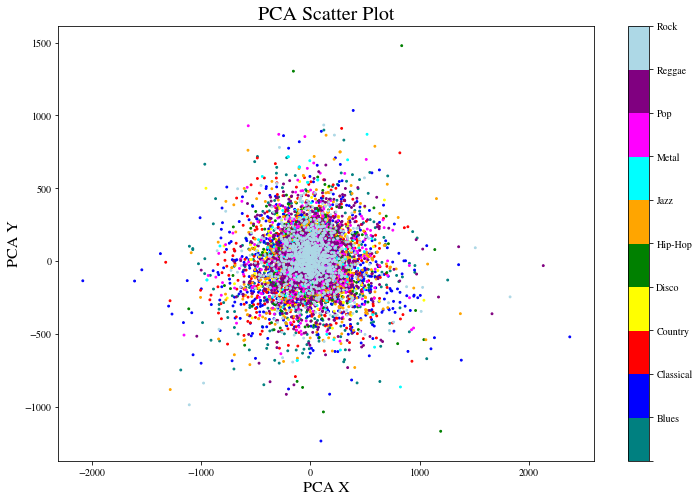

In [25]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# plot_colors = y_raw.map({1:"blue", 2:"red", 3:"yellow", 4:"green", 5:"orange", 6: "cyan", 7: "magenta", 8: "purple", 9: "pink"})
b_list =  [0,1,2,3,4,5,6,7,8,9,10]
m_list = [' ', 'Blues','Classical','Country','Disco','Hip-Hop','Jazz','Metal','Pop','Reggae','Rock']

cmap = matplotlib.colors.ListedColormap(['teal', 'blue','red','yellow', 'green', 'orange', 'cyan','magenta','purple','pink', 'lightblue'])
c_norm = matplotlib.colors.BoundaryNorm(boundaries = b_list, ncolors = 11)


fig, ax = plt.subplots(figsize = (12, 8))
cax = ax.scatter(pca_2.T[0], pca_2.T[1], c = y_raw,  s= 3.5, cmap=cmap, norm=c_norm)
cbar = fig.colorbar(cax)
cbar.set_ticks(b_list)
cbar.set_ticklabels(m_list)

ax.set(title = "PCA Scatter Plot", xlabel = 'PCA X', ylabel = 'PCA Y')
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)

fig.savefig("PCA Scatter Plot.eps", dpi = 300)

plt.show()

In [26]:
# pca_output_final = []
# pca = PCA(n_components=1)
# for i in range(0, len(pca_output[0])):
#     pca_output_final.append(pca.fit(pca_output[i]))
    
# np.array(pca_output_final).shape

In [27]:
# pca_output

# Artificial Neural Network Multi Layer Perceptron (ANN MLP) 

In [28]:
lambda_regularization = 0.001
dropout_rt = 0.2


# Leaving additional layers commented to save memory and time 
model = keras.Sequential([

    #input layer
    keras.layers.Flatten(input_shape=(X_raw.shape[1], X_raw.shape[2])),

#     keras.layers.Dense(2048, activation='relu', kernel_regularizer = keras.regularizers.l2(lambda_regularization)),
#     keras.layers.Dropout(dropout_rt),
    
    keras.layers.Dense(1024, activation='relu', kernel_regularizer = keras.regularizers.l2(lambda_regularization)),
    keras.layers.Dropout(dropout_rt),
    
    keras.layers.Dense(512, activation='relu', kernel_regularizer = keras.regularizers.l2(lambda_regularization)),
    keras.layers.Dropout(dropout_rt),

    keras.layers.Dense(256, activation='relu', kernel_regularizer = keras.regularizers.l2(lambda_regularization)),
    keras.layers.Dropout(dropout_rt),
    
    keras.layers.Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l2(lambda_regularization)),
    keras.layers.Dropout(dropout_rt),
    
    # output layer
    keras.layers.Dense(10, activation='softmax')
])


model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0005),
              loss= 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])


history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 750, epochs= 100)

Epoch 1/100
10/10 [==============================] - 4s 307ms/step - loss: 50.2412 - accuracy: 0.1317 - val_loss: 5.4180 - val_accuracy: 0.1790
Epoch 2/100
10/10 [==============================] - 2s 157ms/step - loss: 10.9387 - accuracy: 0.1631 - val_loss: 4.4920 - val_accuracy: 0.2167
Epoch 3/100
10/10 [==============================] - 2s 164ms/step - loss: 6.3918 - accuracy: 0.1757 - val_loss: 4.6163 - val_accuracy: 0.1674
Epoch 4/100
10/10 [==============================] - 2s 170ms/step - loss: 5.1121 - accuracy: 0.1723 - val_loss: 4.5680 - val_accuracy: 0.1906
Epoch 5/100
10/10 [==============================] - 2s 182ms/step - loss: 4.7634 - accuracy: 0.1844 - val_loss: 4.4865 - val_accuracy: 0.2535
Epoch 6/100
10/10 [==============================] - 2s 164ms/step - loss: 4.6422 - accuracy: 0.2114 - val_loss: 4.4246 - val_accuracy: 0.2739
Epoch 7/100
10/10 [==============================] - 2s 165ms/step - loss: 4.5418 - accuracy: 0.2291 - val_loss: 4.3122 - val_accuracy: 0.29

Epoch 58/100
10/10 [==============================] - 2s 164ms/step - loss: 2.6842 - accuracy: 0.6752 - val_loss: 3.0168 - val_accuracy: 0.5899
Epoch 59/100
10/10 [==============================] - 2s 162ms/step - loss: 2.6715 - accuracy: 0.6769 - val_loss: 3.0054 - val_accuracy: 0.6015
Epoch 60/100
10/10 [==============================] - 2s 159ms/step - loss: 2.6627 - accuracy: 0.6781 - val_loss: 3.0284 - val_accuracy: 0.5979
Epoch 61/100
10/10 [==============================] - 2s 165ms/step - loss: 2.6268 - accuracy: 0.6857 - val_loss: 2.9898 - val_accuracy: 0.6047
Epoch 62/100
10/10 [==============================] - 2s 168ms/step - loss: 2.6209 - accuracy: 0.6840 - val_loss: 2.9846 - val_accuracy: 0.6019
Epoch 63/100
10/10 [==============================] - ETA: 0s - loss: 2.5517 - accuracy: 0.71 - 2s 169ms/step - loss: 2.5521 - accuracy: 0.7126 - val_loss: 2.9384 - val_accuracy: 0.6175
Epoch 64/100
10/10 [==============================] - 2s 167ms/step - loss: 2.5129 - accuracy:

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1690)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1731584   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

# Early stopping? 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


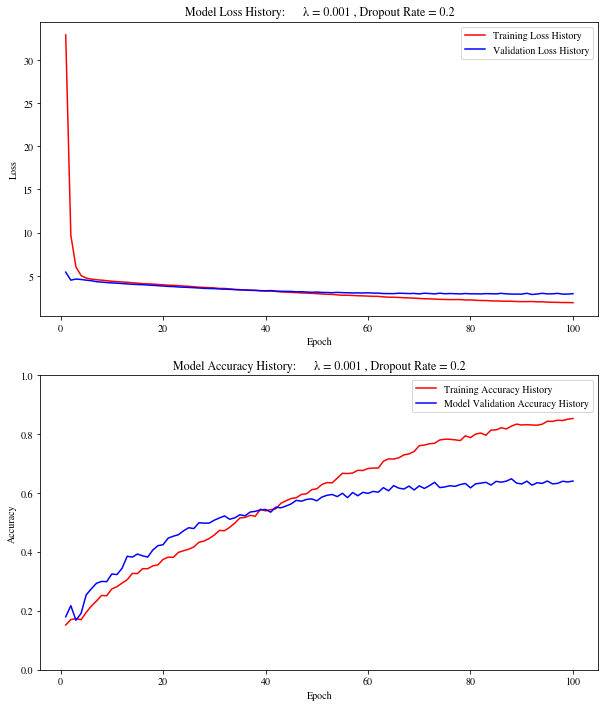

In [30]:
model_loss_history = history.history['loss']
model_val_loss_history = history.history['val_loss']
model_accuracy_list = history.history['accuracy']
model_val_accuracy_list = history.history['val_accuracy']


parameter_string = '     λ = ' + str(lambda_regularization) + ' , Dropout Rate = ' + str(dropout_rt)
file_save_string = 'lambda_' + str(lambda_regularization) + ' - dropout_rt_' + str(dropout_rt) + '.eps'


# plt.style.use('ggplot')
plt.figure(figsize = (10,8))

plt.subplot(2,1,1)
plt.title('Model Loss History: ' + parameter_string)
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim(0, 150)
plt.plot(np.arange(1, len(model_loss_history) + 1), model_loss_history, color = 'r', label = 'Training Loss History')
plt.plot(np.arange(1, len(model_val_loss_history) + 1), model_val_loss_history, color = 'b', label = 'Validation Loss History')
plt.legend()


plt.subplot(2,1,2)
plt.title('Model Accuracy History: ' + parameter_string)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.plot(np.arange(1, len(model_accuracy_list) + 1), model_accuracy_list, color = 'r', label = 'Training Accuracy History')
plt.plot(np.arange(1, len(model_val_accuracy_list) + 1), model_val_accuracy_list, color = 'b', label = 'Model Validation Accuracy History')
plt.legend()
plt.subplots_adjust(top = 1.25)
plt.savefig(file_save_string, dpi=300, bbox_inches = 'tight', pad_inches = 0.5)

plt.show()

In [31]:
print("Final Training Accuracy: ", "{:.2%}".format(model_accuracy_list[-1]))
print("Final Validation Accuracy: ", "{:.2%}".format(model_val_accuracy_list[-1]))

Final Training Accuracy:  85.23%
Final Validation Accuracy:  64.00%


### Using Plots to Conclude Optimal Paramaters: 

Model Paramaters:

    - Fully Connected Layers: 3
    - Learning Rate = 0.0005
    - Batch Size = 750
    - Epochs = 100


Overfitting Paramaters:

     - Lambda = 0.0025
     - Dropout Layers = 3
     - Dropout Rate = 0.2 (20%)

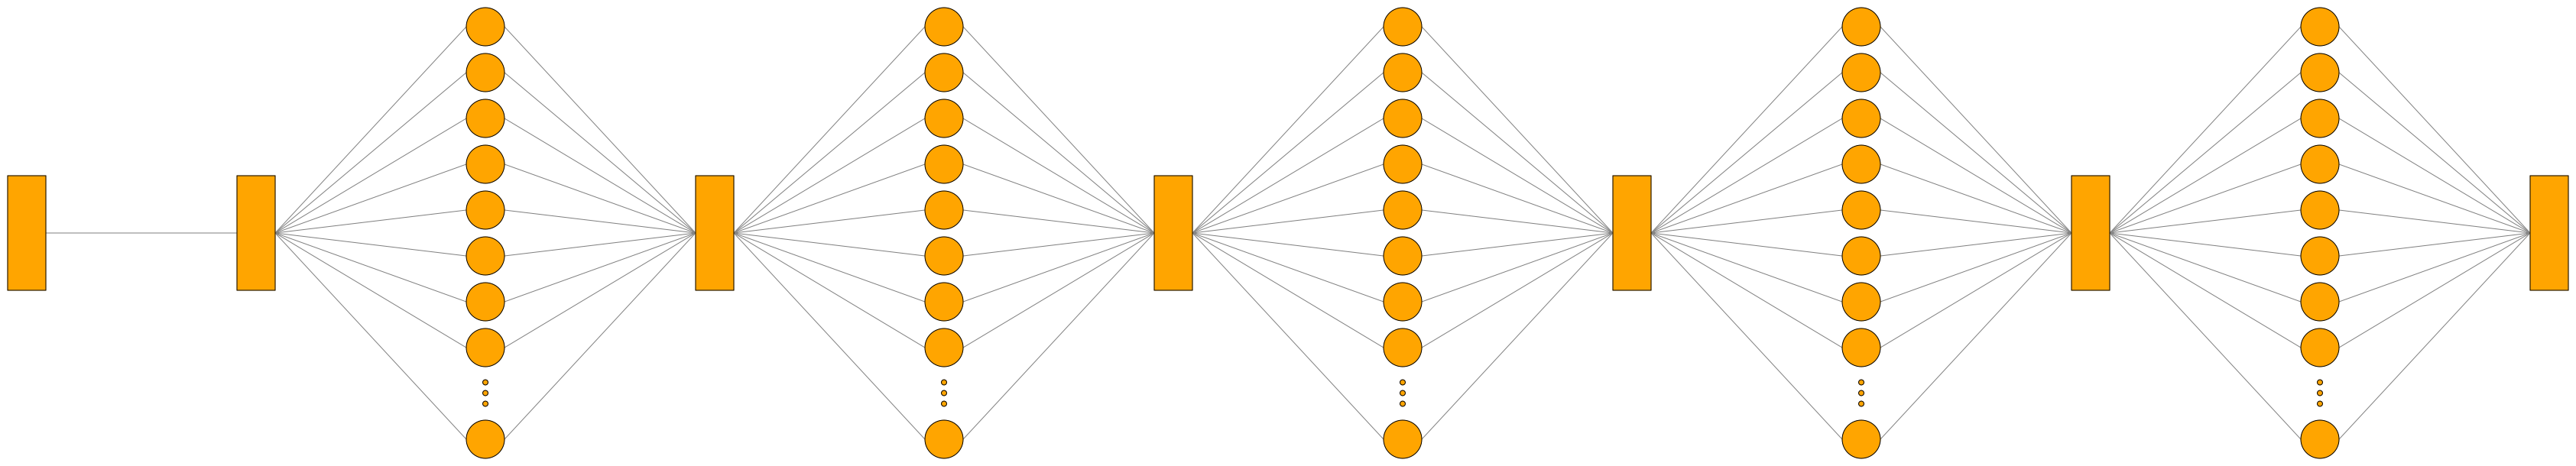

In [32]:
import visualkeras
visualkeras.graph_view(model, to_file = 'Network_Plot.png')

In [33]:
visualkeras.layered_view(model)

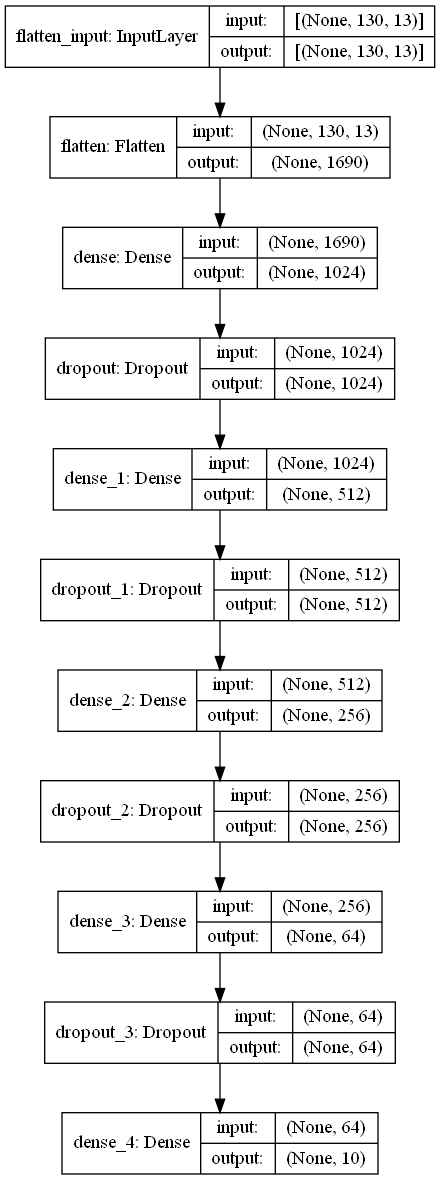

In [34]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [35]:
model.predict(X_test).shape

(2497, 10)

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

y_pred_test = np.argmax(model.predict(X_test), axis = 1)

test_accuracy = metrics.accuracy_score(y_test, y_pred_test)
test_f1_score = metrics.f1_score(y_test, y_pred_test, average="micro")

test_precision = metrics.precision_score(y_test, y_pred_test, average = 'micro')
test_recall = metrics.recall_score(y_test, y_pred_test, average = 'micro')

print(f"Testing Set Accuracy: {test_accuracy*100:.3f}%")
print(f"Testing Set F1 Score: {test_f1_score:.3f}")
# print(f"Testing Set Precision: {test_precision:.3f}")
# print(f"Testing Set Recall: {test_recall:.3f}")

Testing Set Accuracy: 63.997%
Testing Set F1 Score: 0.640


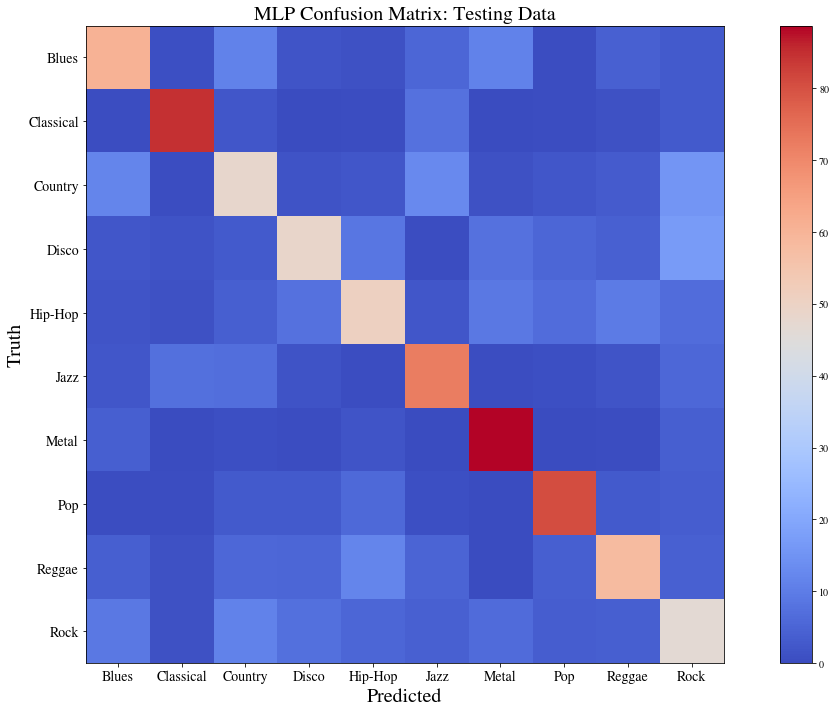

In [38]:
confusion_training = confusion_matrix(y_test, y_pred_test)

confusion_training = confusion_training.astype("float") / confusion_training.sum(axis=1)[:, np.newaxis]

confusion_training = np.around(confusion_training, decimals=3)*100

genre_list = ['Blues','Classical','Country','Disco','Hip-Hop','Jazz','Metal','Pop','Reggae','Rock']

#create confusion matrix heat map
f, axes = plt.subplots(figsize=(16,10))
im = axes.imshow(confusion_training, interpolation="nearest", cmap = plt.cm.coolwarm)

axes.figure.colorbar(im, ax=axes)
axes.set(title="MLP Confusion Matrix: Testing Data", \
         xticks=np.arange(confusion_training.shape[1]), \
         yticks=np.arange(confusion_training.shape[0]), \
         xticklabels= genre_list, yticklabels= genre_list, \
         xlabel="Predicted", ylabel="Truth")
axes.grid(False)
axes.tick_params(axis='x', labelsize=14)
axes.tick_params(axis='y', labelsize=14)
axes.title.set_fontsize(20)
axes.xaxis.label.set_fontsize(20)
axes.yaxis.label.set_fontsize(20)


#add clear annotations to the confusion matrix
# threshold = confusion_training.max()/1.5
# for i in range(confusion_training.shape[0]):
#     for j in range(confusion_training.shape[1]):
#         axes.text(j, i, f"{confusion_training[i, j]:.0f}%",
#                 ha="center", va="center",
#                 color="white" if confusion_training[i, j] > threshold else "black")
        
f.tight_layout()
plt.savefig('MLP Testing Confusion.png', dpi = 300)
plt.show()

### Predict On Unseen Data

In [39]:
#Use sample file 
MFCC_test = np.array([])

signal, sample_rate = librosa.load('blues.00000.wav', sr=SAMPLE_RATE)

samples_per_segment = int(SAMPLES_PER_TRACK / 5)

data = {
    "mfcc": []
}

for d in range(5):

    start = samples_per_segment * d
    finish = start + samples_per_segment

    mfcc = librosa.feature.mfcc(signal[start:finish], 22050, n_mfcc=13, n_fft=2048, hop_length=512)
    mfcc = mfcc.T

    if len(mfcc) == math.ceil(samples_per_segment / 512):
#         MFCC_test = np.append(MFCC_test, mfcc.tolist() )
        data["mfcc"].append(mfcc.tolist())

with open('test_song.json', "w") as d:
    json.dump(data, d, indent=4)
    

with open('c:/Users/StevensUser/Desktop/Audio_Analysis/test_song.json', "r") as fp:
    data = json.load(fp)

X_sample_test = np.array(data["mfcc"])

In [40]:
# X_sample_test_v2 = X_sample_test.reshape(1, len(X_sample_test[0]) * 5, 13 )
# X_sample_test_v2 = X_sample_test_v2[0, :130]
# # X_sample_test_v2.shape
# model.predict(X_sample_test_v2)

In [73]:
# Predicting on Validation data 
np.set_printoptions(suppress=True)

reverse_genre_lookup = {1: 'blues', 2: 'classical', 3: 'country', 
              4: 'disco', 5: 'hiphop', 6: 'jazz', 
              7: 'metal', 8: 'pop', 9: 'reggae', 
              10: 'rock'}

pred_sample = model.predict(X_test)[29] #Arbitrary Sample
pred_class = reverse_genre_lookup[np.argmax(pred_sample) + 1]

print(pred_sample)
print(pred_class)

[0.04783473 0.01198756 0.14292142 0.22570407 0.02498336 0.02777928
 0.02803008 0.00615724 0.02948704 0.4551152 ]
rock


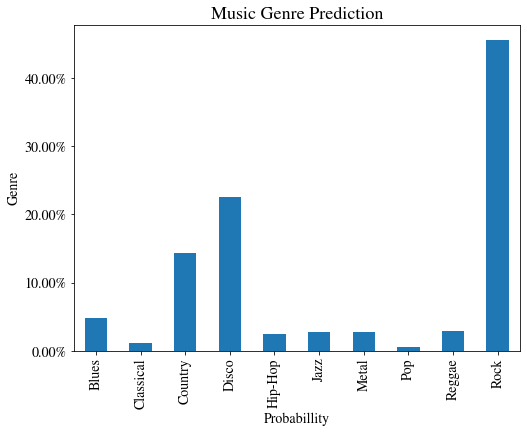

In [74]:
pred_output_data = {'Blues': pred_sample[0],
                'Classical': pred_sample[1],
                'Country': pred_sample[2],
                'Disco': pred_sample[3],
                'Hip-Hop': pred_sample[4],
                'Jazz': pred_sample[5],
                'Metal': pred_sample[6],
                'Pop': pred_sample[7],
                'Reggae': pred_sample[8],
                'Rock': pred_sample[9]}
pred_output_df = pd.DataFrame(data = pred_output_data, index = ['Class Probability']).T

fig, ax = plt.subplots(figsize = (8, 6))

pred_output_df['Class Probability'].plot.bar()
ax.set_title('Music Genre Prediction', fontsize = 14)
ax.set_xlabel('Probabillity', fontsize = 12)
ax.set_ylabel('Genre', fontsize = 12)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.title.set_fontsize(18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)


vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

# fig.text(0.5, 0.01, dummy_review,  wrap=True, horizontalalignment='center', fontsize=12)
fig.savefig("Genre Estimation.eps", dpi = 300)

plt.show()


In [43]:
end_time = datetime.now()
print ("Completed, Runtime: ", end_time -start_time)

Completed, Runtime:  0:12:50.162457


In [1]:
#http://marsyas.info/downloads/datasets.html
#https://www.eecg.utoronto.ca/~jayar/mie324/musicgenre.pdf
#https://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/
#https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/